### Graphical representation of anisotropy from 6C data

author: Sebastian Noe, snoe@geophysik.uni-muenchen.de

This notebook provides the possibility to produce colorful pictures of the anisotropy of arbritrarily complex media. The velocities are **not** analytically calculated but rather the estimated values based on synthetic 6C seismograms. The workflow is as follows:

    1) Synthetize seismograms of arbitrary anisotropy and direction 
    2) The direction of propagation is estimated via the polarization of rotational components
    3) The seismogram is rotated such that the x-axis is parallel to the direction of propagation
    4) A second rotation around the x-axis provides qS1 and qS2 appearing on separate axis
    5) Velocities of all three phases are estimated by taking appropriate ratios
    6) Plot the results in a horizontal projection

__Cell 0:__

We import usual packages. 
Additionally, necessary external functions to calculate synthetic seismograms in an anisotropic setting are called.

(Note: further explanations are given in "functions_anisotropy.py")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
import matplotlib.tri as tri

__Cell 1:__


Get a list of available anisotropic media. 

VTI media from Thomsen (1986).

In [2]:
medium = load_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz


__Cell 3:__

Here, we load an elastic tensor. You can change the index to try out different anisotropic media.
It's possible to display all six values (vertical p-wave velocity, vertical shear wave velocity, $\epsilon$,$\delta$,$\gamma$ and density). 
If you want to change specific parameters, you must add the line _parameter = new_parameter_ inside the function, e.g. _eps=new_eps_, where only new parameters are changed while all unspecified values remain the same. 

Optionally you can try your luck and generate a random elastic tensor. Various symmetries are available. The number inside the function drives the spreading off the values. Beware! Some elastic tensors may be unphyiscal (negative eigenvalues, negative entries etc)

In [3]:
index = 6
C, density = get_specific_VTI(medium[index],give_thomsen=True)

#C, density = get_random_C('triclinic',20)
# available random symmetries: 'isotropic','cubic','VTI','tetragonal', \
#                              'trigonal','orthorhombic','monoclinic','triclinic'

quartz
 
vp0     = 6096
vs0     = 4481
eps     = -0.096
delta   = 0.273
gamma   = -0.159
density = 2650
 
[[79.5695957   6.99073743 13.74513146  0.          0.          0.        ]
 [ 6.99073743 79.5695957  13.74513146  0.          0.          0.        ]
 [13.74513146 13.74513146 98.4772224   0.          0.          0.        ]
 [ 0.          0.          0.         53.21030665  0.          0.        ]
 [ 0.          0.          0.          0.         53.21030665  0.        ]
 [ 0.          0.          0.          0.          0.         36.28942914]]


__Cell 4:__

The above workflow is applied here. You have multiple options to sample the space. The most effective way is to use 'planar'-mode. $N$ gives the amount of directions sitting on one plane. It should always be an even number in order to avoid the direction $(0,0,1)^T$ where some symmetries have trouble to estimate qP-velocities. Purely horizontal directions are automatically discarded. $N_p$ drives the number of planes that are regularly spaced in horizontal direction. Alas, $N\cdot N_p$ is the total amount of events. If you don't want the planes to include the z-axis, you can modify $\theta_e\in[0,90]$. It gives the minimal vertical angle of the planes.

Another option is to use 'random'-mode. The total amount of random directions is $N_p\cdot N$. Keep in mind that directions close to the z-axis will be poorly sampled. Due to uneven sampling there are definitely more events necessary to produce roughly comparable results to 'planar'-mode, however it's the more realistic approach.

As of right now, the probability density function of horizontal angles is a constant. In the future this may be changed to further see effects of uneven sampling.

To keep obtained results comparable, true velocity directions and true velocities are stored.

For low-symmetry systems it's recommended to use higher frequencies as the applied methods may have problems for low-frequency signals. High frequencies provide narrower peaks.

The computation may take a while. Progress is printed.

In [4]:
f = 100.
fs = 100.
Np = 12
N = 12
mode = 'planar'   #'planar','random'
theta_e = 0.


phi_e = np.linspace(0,180.,Np+1)
nu_t = []
vel_t = []
est_nu_t = []
est_vel_t = []

k = 0
fac = 100/(N*Np)
for j in range(0,Np):
    nus, gammas = get_direction(mode,C,N+2,phi_e = phi_e[j],theta_e=theta_e)
    nu_t.extend(nus[1:N+1])

    for i in range(1,N+1):
        k += 1
        print(str(round(k*fac,1))+'%')
        vel,v = get_eigenvals(gammas[i], density)
        vel_s = extract_slower_velocities(vel)
        seis, t = get_seis(v, vel, nus[i], f, fs)
        
        nu_e = get_propagation_direction(seis)
        vel_e, _ , _ = estimate_velocity(seis, nu_e,t)
        
        vel_t.append([max(vel),vel_s[0],vel_s[1]])
        est_nu_t.append(nu_e)
        est_vel_t.append(vel_e)

### Organizing recovered values        
        
angles = np.zeros((k,2))
r2d = 180/np.pi
for i in range(0,k):
    theta,phi = get_angles(est_nu_t[i])
    angles[i][0] = (theta * r2d)%90
    angles[i][1] = (phi * r2d)%360
    
angles_r = np.zeros((k,2))
for i in range(0,k):
    theta,phi = get_angles(nu_t[i])
    angles_r[i][0] = (theta * r2d)%90
    angles_r[i][1] = (phi * r2d)%360    

qP = np.zeros(k)
qS1 = np.zeros(k)
qS2 = np.zeros(k)
for i in range(0,k):
    qP[i] = est_vel_t[i][0]
    qS1[i] = est_vel_t[i][1]
    qS2[i] = est_vel_t[i][2]
    
qP_r = np.zeros(k)
qS1_r = np.zeros(k)
qS2_r = np.zeros(k)
for i in range(0,k):
    qP_r[i] = vel_t[i][0]
    qS1_r[i] = vel_t[i][1]
    qS2_r[i] = vel_t[i][2] 
    
    

0.7%
1.4%
2.1%
2.8%
3.5%
4.2%
4.9%
5.6%
6.2%
6.9%
7.6%
8.3%
9.0%
9.7%
10.4%
11.1%
11.8%
12.5%
13.2%
13.9%
14.6%
15.3%
16.0%
16.7%
17.4%
18.1%
18.8%
19.4%
20.1%
20.8%
21.5%
22.2%
22.9%
23.6%
24.3%
25.0%
25.7%
26.4%
27.1%
27.8%
28.5%
29.2%
29.9%
30.6%
31.2%
31.9%
32.6%
33.3%
34.0%
34.7%
35.4%
36.1%
36.8%
37.5%
38.2%
38.9%
39.6%
40.3%
41.0%
41.7%
42.4%
43.1%
43.8%
44.4%
45.1%
45.8%
46.5%
47.2%
47.9%
48.6%
49.3%
50.0%
50.7%
51.4%
52.1%
52.8%
53.5%
54.2%
54.9%
55.6%
56.2%
56.9%
57.6%
58.3%
59.0%
59.7%
60.4%
61.1%
61.8%
62.5%
63.2%
63.9%
64.6%
65.3%
66.0%
66.7%
67.4%
68.1%
68.8%
69.4%
70.1%
70.8%
71.5%
72.2%
72.9%
73.6%
74.3%
75.0%
75.7%
76.4%
77.1%
77.8%
78.5%
79.2%
79.9%
80.6%
81.2%
81.9%
82.6%
83.3%
84.0%
84.7%
85.4%
86.1%
86.8%
87.5%
88.2%
88.9%
89.6%
90.3%
91.0%
91.7%
92.4%
93.1%
93.8%
94.4%
95.1%
95.8%
96.5%
97.2%
97.9%
98.6%
99.3%
100.0%


__Cell 5:__

Plot the results. It's in a horizontal projection. x-axis is to the right, y-axis to the top and the z-axis is in the centre. Horizontal incoming events are plotted on the side and verticals are in the center.
It will give one plot per wavetype, each having it's own colorscale. The colors are triangulated between measured points. Data points are plotted in black. Variable _levels_ drives the intermediate steps of the colorscale - high levels result in more computation time but also making plots more continuous.

Change the boolean _save_c_ to _True_ if you want to save the plots. The name of the elastic tensor can be given in _save_.

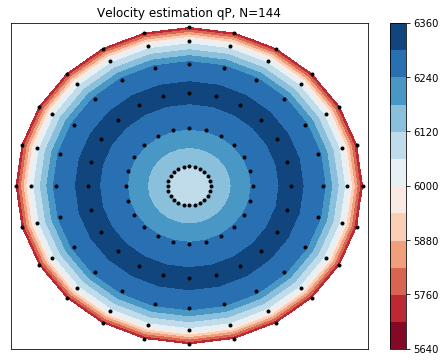

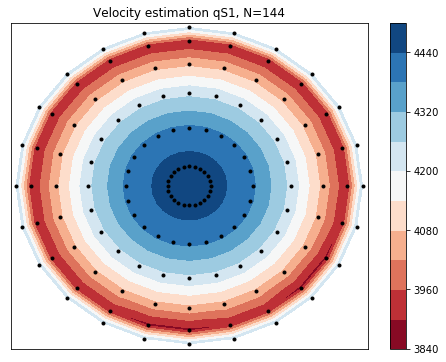

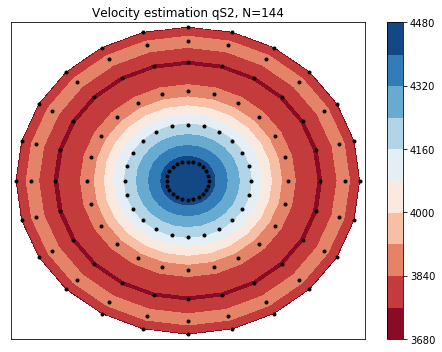

In [5]:
levels = 10
save_c = False
save = 'example'

d2r = np.pi/180.
x = np.cos(angles[:,1]*d2r)*np.sin(angles[:,0]*d2r)
y = np.sin(angles[:,1]*d2r)*np.sin(angles[:,0]*d2r)
xi = np.linspace(-1, 1, 1000)
yi = np.linspace(-1, 1, 1000)

triang = tri.Triangulation(x, y)
Xi, Yi = np.meshgrid(xi, yi)

fig = plt.figure(figsize=(8,6))
z = qP
interpolator = tri.LinearTriInterpolator(triang, z)
zi = interpolator(Xi, Yi)
ax1 = plt.subplot(111)
cntr1 = ax1.contourf(xi, yi, zi, levels=levels, cmap="RdBu")
fig.colorbar(cntr1, ax=ax1)
ax1.plot(x, y, 'ko', ms=3, color='black')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Velocity estimation qP, N='+str(k))
if save_c:
    plt.savefig('./estimation_plots/'+save+'_qP.png')

fig = plt.figure(figsize=(8,6))
z = qS1
interpolator = tri.LinearTriInterpolator(triang, z)
zi = interpolator(Xi, Yi)
ax2 = plt.subplot(111)
cntr2 = ax2.contourf(xi, yi, zi, levels=levels, cmap="RdBu")
fig.colorbar(cntr2, ax=ax2)
ax2.plot(x, y, 'ko', ms=3, color='black')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Velocity estimation qS1, N='+str(k))
if save_c:
    plt.savefig('./estimation_plots/'+save+'_qS1.png')

fig = plt.figure(figsize=(6.5,5))
z = qS2
interpolator = tri.LinearTriInterpolator(triang, z)
zi = interpolator(Xi, Yi)
ax3 = plt.subplot(111)
cntr3 = ax3.contourf(xi, yi, zi, levels=levels, cmap="RdBu")
fig.colorbar(cntr3, ax=ax3)
ax3.plot(x, y, 'ko', ms=3, color='black')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Velocity estimation qS2, N='+str(k))
if save_c:
    plt.savefig('./estimation_plots/'+save+'_qS2.png')

plt.tight_layout()
plt.show()



__Cell 6:__

Copy and paste of Cell 5 with the difference of plotting the error of estimated velocities. 

For very good estimations, the colorbar may have insignificant scales (e.g. $10^{-5}$).

Change _save_c_ to change plots. The name is the same than previous cell with suffix _error_. 

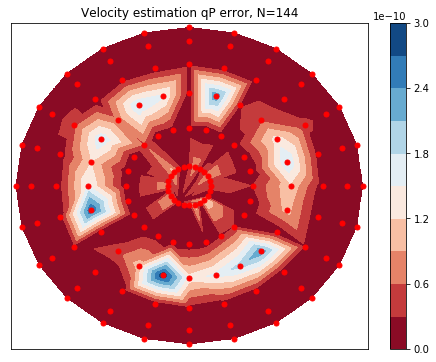

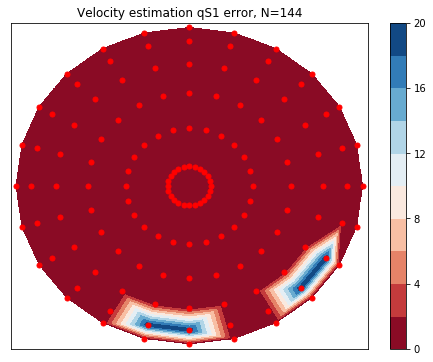

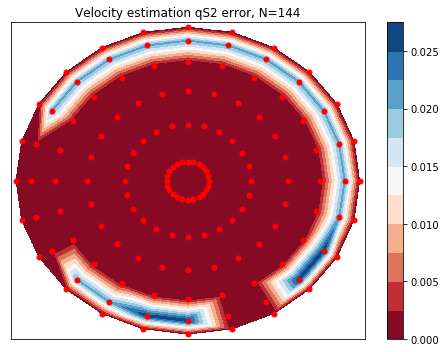

In [6]:
levels = 10
save_c = False

x = np.cos(angles_r[:,1]*d2r)*np.sin(angles_r[:,0]*d2r)
y = np.sin(angles_r[:,1]*d2r)*np.sin(angles_r[:,0]*d2r)

plt.figure(figsize=(8,6))
z = abs(qP-qP_r)
interpolator = tri.LinearTriInterpolator(triang, z)
zi = interpolator(Xi, Yi)
ax1 = plt.subplot(111)
cntr1 = ax1.contourf(xi, yi, zi, levels=levels, cmap="RdBu")
fig.colorbar(cntr1, ax=ax1)
ax1.plot(x, y, 'ko', ms=5, color='red')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Velocity estimation qP error, N='+str(k))
if save_c:
    plt.savefig('./estimation_plots/'+save+'_error_qP.png')

plt.figure(figsize=(8,6))
z = abs(qS1-qS1_r)
interpolator = tri.LinearTriInterpolator(triang, z)
zi = interpolator(Xi, Yi)
ax2 = plt.subplot(111)
cntr2 = ax2.contourf(xi, yi, zi, levels=levels, cmap="RdBu")
fig.colorbar(cntr2, ax=ax2)
ax2.plot(x, y, 'ko', ms=5, color='red')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Velocity estimation qS1 error, N='+str(k))
if save_c:
    plt.savefig('./estimation_plots/'+save+'_error_qS1.png')

plt.figure(figsize=(6.5,5))
z = abs(qS2-qS2_r)
interpolator = tri.LinearTriInterpolator(triang, z)
zi = interpolator(Xi, Yi)
ax3 = plt.subplot(111)
cntr3 = ax3.contourf(xi, yi, zi, levels=levels, cmap="RdBu")
fig.colorbar(cntr3, ax=ax3)
ax3.plot(x, y, 'ko', ms=5, color='red')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Velocity estimation qS2 error, N='+str(k))
if save_c:
    plt.savefig('./estimation_plots/'+save+'_error_qS2.png')

plt.tight_layout()
plt.show()
